In [15]:
import pandas as pd
import json

## Plot the workflow

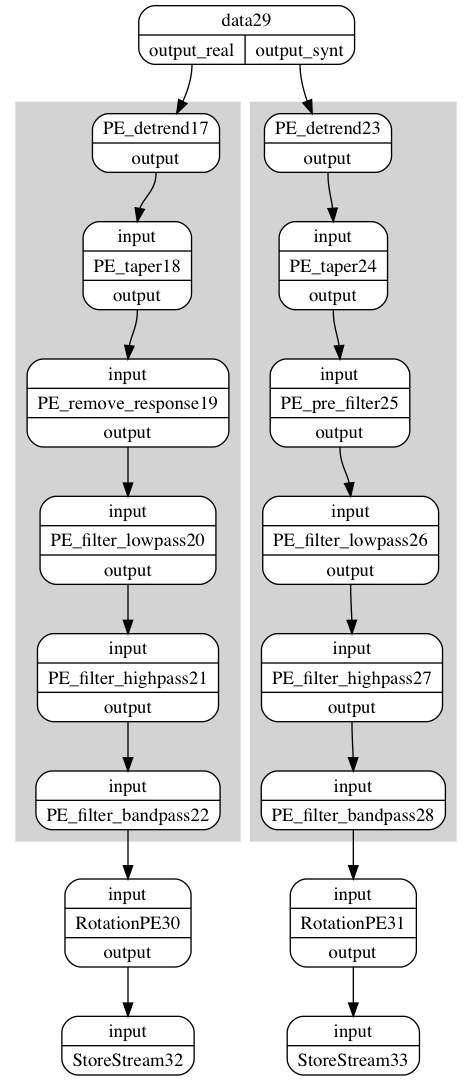

In [413]:
from IPython.display import Image
Image(filename='misfit.png') 

In [16]:
df=pd.read_csv("monitor_misfit.csv")
df.head()

,PE,rank,method,data,start,end
0,data29,0,read,{'input': []},1.566483e+09,1.566483e+09
1,data29,0,preprocess,{},1.566483e+09,1.566483e+09
2,data29,0,write,"{'output': 'output_real', 'size': 1031, 'id': ...",1.566483e+09,1.566483e+09
3,data29,0,write,"{'output': 'output_synt', 'size': 1031, 'id': ...",1.566483e+09,1.566483e+09
4,PE_detrend23,11,read,"{'input': [('input', ('data29', 0, 'output_syn...",1.566483e+09,1.566483e+09


## Communication times

In [19]:
def communication_time(df):
    write_logs = df.loc[df['method'] == 'write'][['PE', 'rank', 'start', 'end', 'data']]
    wcols = write_logs['data'].apply(eval).map(lambda d: [d['id'], d['size']]).apply(pd.Series)
    write_logs['data_id'] = wcols[0]
    write_logs['data_size'] = wcols[1]
    write_logs = write_logs.drop(columns=['data'])
    
    read_logs = df.loc[df['method'] == 'read'][['PE', 'rank', 'start', 'end', 'data']]
    rcols = read_logs['data'].apply(eval).map(lambda d: d['input']).apply(pd.Series)
    read_logs['data_id'] = rcols[0].map(lambda t : t[1] if isinstance(t, tuple) else None)
    read_logs = read_logs[read_logs['data_id'].notnull()]
    read_logs = read_logs.drop(columns=['data'])
    
    jdf = read_logs.set_index('data_id').join(write_logs.set_index('data_id'), lsuffix='_r', rsuffix='_w')
    jdf['t_comm'] = jdf[['end_w', 'end_r']].max(axis=1) - jdf[['start_r', 'start_w']].max(axis=1)
    communication_times = jdf[['PE_w', 'rank_w', 'PE_r', 'rank_r', 't_comm']]
    ct = communication_times[['PE_w', 'PE_r', 't_comm']].groupby(['PE_w', 'PE_r']).mean()
    return ct

In [20]:
ct=communication_time(df) 
ct

,,t_comm
PE_w,PE_r,
PE_detrend17,PE_taper18,0.013465
PE_detrend23,PE_taper24,0.014700
PE_filter_bandpass22,RotationPE30,0.016172
PE_filter_bandpass28,RotationPE31,0.013977
PE_filter_highpass21,PE_filter_bandpass22,0.013450
PE_filter_highpass27,PE_filter_bandpass28,0.014871
PE_filter_lowpass20,PE_filter_highpass21,0.014278
PE_filter_lowpass26,PE_filter_highpass27,0.013106
PE_pre_filter25,PE_filter_lowpass26,0.013057


## Processing times

Retrieve the processing times for each PE instance

In [21]:
def processing_times(df):
    pl = df.loc[df['method'] == 'process'][['PE', 'rank', 'start', 'end']]
    pl['t_proc'] = pl['end'] - pl['start']
    processing_times = pl.drop(columns=['start', 'end'])
    pt= processing_times[['PE', 't_proc']].groupby(['PE']).mean()
    return pt

In [22]:
pt=processing_times(df)
pt

,t_proc
PE,
PE_detrend17,0.023780
PE_detrend23,0.009589
PE_filter_bandpass22,0.005428
PE_filter_bandpass28,0.007088
PE_filter_highpass21,0.006630
PE_filter_highpass27,0.009092
PE_filter_lowpass20,0.004395
PE_filter_lowpass26,0.004529
PE_pre_filter25,0.001526


Calculate the average processing time for each PE

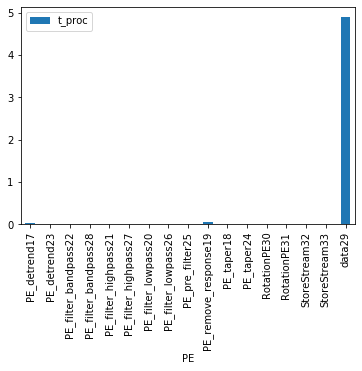

In [23]:
import matplotlib.pyplot as plt
pt.plot(kind='bar')
plt.show()

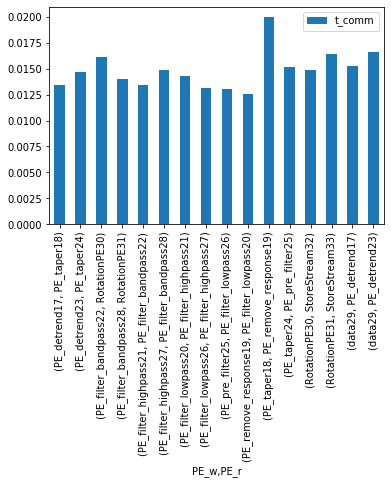

In [24]:
ct.plot(kind='bar')
plt.show()

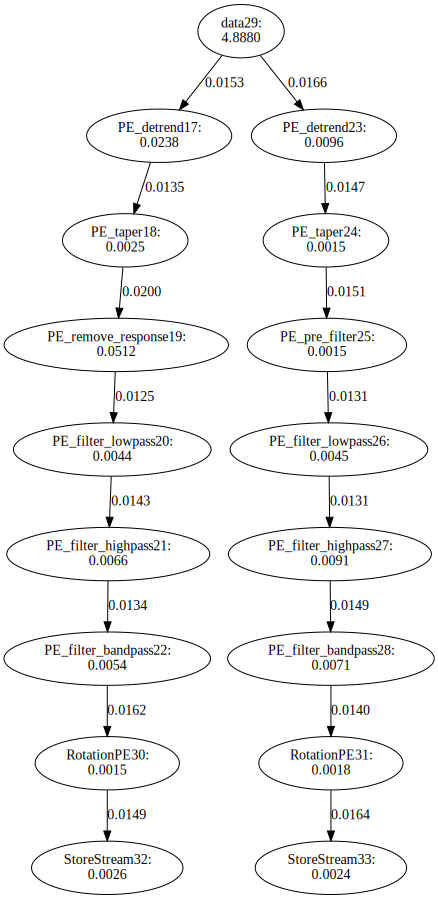

In [29]:
from graphviz import Digraph

f = Digraph('misfit_times', filename='misfit_time.gv')
f.attr(size='20,20')
f.attr('node', shape='oval')

def add_node(r):
    f.node(r.name, label='%s: \n%.4f' % (r.name, r['t_proc']))
def add_edge(r):
    f.edge(r.name[0], r.name[1], label='%.4f' % r['t_comm'])

pt.apply(add_node, axis=1)
ct.apply(add_edge, axis=1)

f

In [30]:
f.render(filename='misfit_time', format="png")

'misfit_time.png'

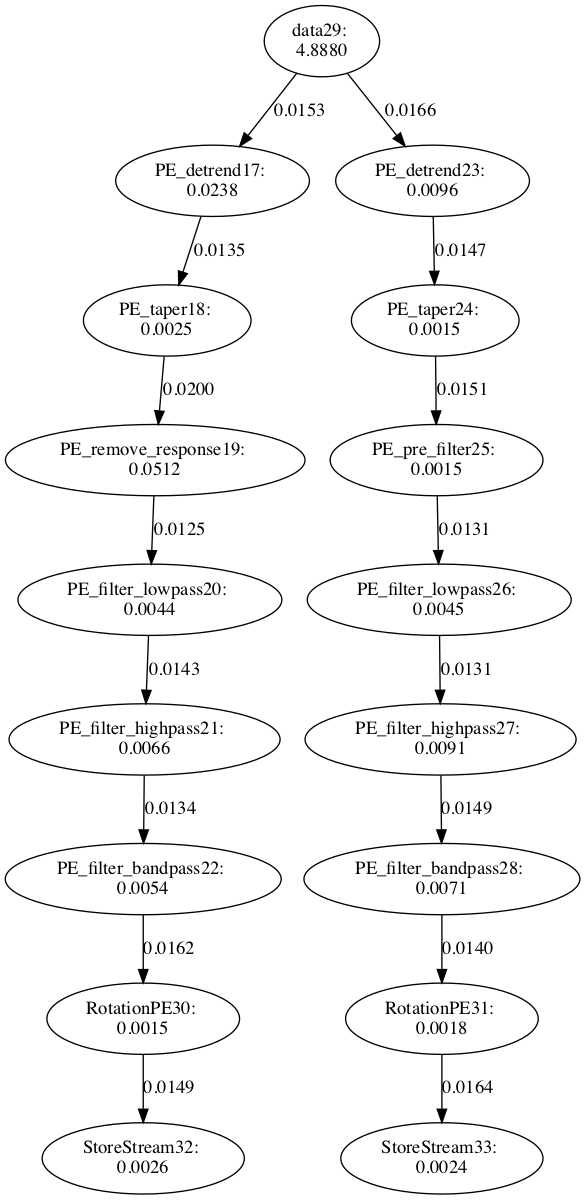

In [31]:
from IPython.display import Image
Image(filename='misfit_time.png') 